# Ultimate Technologies Inc. Take-Home Challenge
By Hanna Seyoum

Ultimate Technologies Inc. is an American worldwide online transportation network company that has disrupted the taxi and logistics industry and is a prestigious company to work at.

The goal of this challenge is to analyze user logins and predict rider retention.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.7)
sns.set_palette("Greens_r")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import auc, precision_recall_curve
from sklearn.metrics import roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

**Part 1: EDA**

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. I will aggregate these login counts based on 15-minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand.

In [2]:
df_logins = pd.read_json("logins.json")

In [3]:
df_logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


`login_time` is already in datetime format.

In [4]:
df_15min = df_logins.resample("15Min", on="login_time").count()
df_15min.rename(columns={"login_time": "login_count"}, inplace=True)

In [5]:
df_15min.head()

,login_count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


Text(0, 0.5, 'Number of Logins')

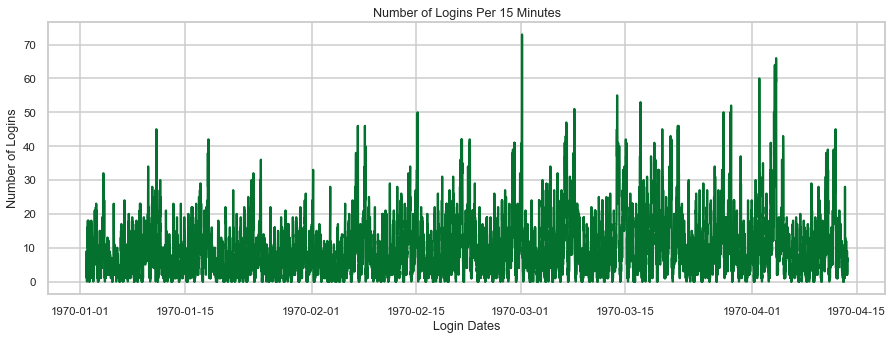

In [6]:
plt.subplots(figsize = (15,5))
plt.plot(df_15min.index, df_15min.login_count)
plt.title("Number of Logins Per 15 Minutes")
plt.xlabel("Login Dates")
plt.ylabel("Number of Logins")

It's clear from the above plot that there is a trend with the number of logins. I will investigate further by calculating the number of logins by the day of the week.

In [7]:
df_login_weekdays = df_logins.resample("B", on="login_time").count().rename(columns={"login_time": "login_count"})
df_login_fri = df_logins.resample("W-FRI", on="login_time").count().rename(columns={"login_time": "login_count"})
df_login_sat = df_logins.resample("W-SAT", on="login_time").count().rename(columns={"login_time": "login_count"})
df_login_sun = df_logins.resample("W-SUN", on="login_time").count().rename(columns={"login_time": "login_count"})

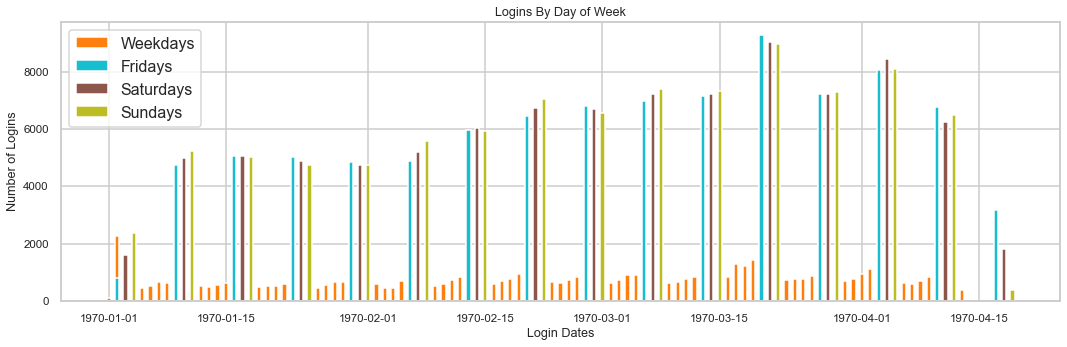

In [8]:
plt.subplots(figsize = (15,5))

plt.bar(df_login_weekdays.index, df_login_weekdays.login_count, width=0.5, label="Weekdays", color="tab:orange")
plt.bar(df_login_fri.index, df_login_fri.login_count, width=0.5, label="Fridays", color="tab:cyan")
plt.bar(df_login_sat.index, df_login_sat.login_count, width=0.5, label="Saturdays", color="tab:brown")
plt.bar(df_login_sun.index, df_login_sun.login_count, width=0.5, label="Sundays", color="tab:olive")

plt.title("Logins By Day of Week")
plt.xlabel("Login Dates")
plt.ylabel("Number of Logins")

plt.legend(loc="upper left", fontsize = 16)
plt.tight_layout()

We can see in the above plot that there are more logins during the weekends (Friday, Saturday, & Sunday) than the weekdays. This is expected as more people go out during the weekend when they don't have work. 

**Part 2: Experiment and metrics design**  

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.  

However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.  

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

a. how you will implement the experiment  
b. what statistical test(s) you will conduct to verify the significance of the observation    
c. how you would interpret the results and provide recommendations to the city  
operations team along with any caveats.

The metric I would use as a measure of success of this experiement in encouraging driver partners to serve both cities by reimbursing all toll costs is the average number of accepted rides (or the average number of trips made by drivers) in each city on weekdays.

To conduct the experiment I would conduct a hypothesis test.  
$H_{0}$: toll incentive has not increased the average number of trips taken during the week (excluding weekends)  
$H_{A}$: toll incentive has increased the average number of trips taken during the week (excluding weekends)

Since I am interested in checking if there is an increase in number of trips, I will do a one-sided t-test.

Once I calculate the t-statistic, the p-value is returned. If this p-value is less than 0.5, I reject the null hypothesis that the toll incentive has not increased the average number of trips taken during the week. If this is the case, I would advice the managers not to start the reimbursement strategy. And if the p-value is greater than 0.5, I fail to reject the null hypothesis, and I would recommend to the managers that they go forward with their proposed incentive.

**Part 3:**  

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014.  
___
create `user-retained` feature:   
1: user was “active” (i.e. took a trip) in the preceding 30 days  
0: otherwise

-make this feature the target feature  
-classification problem  

___
Use this dataset to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

In [9]:
df_ultimate_data = pd.read_json("ultimate_data_challenge.json")

In [10]:
df_ultimate_data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [11]:
user_retained = []

for i in range(len(df_ultimate_data)):
    if df_ultimate_data["trips_in_first_30_days"][i] > 0:
        user_retained.append(1)
    else:
        user_retained.append(0)

df_ultimate_data["user_retained"] = user_retained

In [12]:
df_ultimate_data["user_retained"].value_counts()

1    34610
0    15390
Name: user_retained, dtype: int64

In [13]:
retained_percent = round(df_ultimate_data["user_retained"].mean(), 2) * 100
print("The percentage of adopted users is {}%".format(retained_percent))

The percentage of adopted users is 69.0%


We see that 69% of users are retained. I will investigate which features may help increase that percentage. Also, since the dataset is not too imbalanced, I will plot the ROC curve instead of the precision recall curve.

In [14]:
df_ultimate_data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,user_retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,1
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,1


In [15]:
df = df_ultimate_data.copy()

In [16]:
df["signup_date"] = pd.to_datetime(df["signup_date"])
df["last_trip_date"] = pd.to_datetime(df["last_trip_date"])

In [17]:
is_active = []
for i in range(len(df)):
    if (df["last_trip_date"].max() - df["last_trip_date"][i]).days > 30:
        active = 0
    else:
        active = 1
    is_active.append(active)

In [18]:
df["is_active"] = is_active

In [19]:
driver_lifespan = []
for i in range(len(df)):
    days = (df["last_trip_date"].max() - df["signup_date"][i]).days
    driver_lifespan.append(days)

In [20]:
df["days_since_signup"] = driver_lifespan

Now that I've created the features `is_active` and `driver_lifespan` from `signup_date` and `last_trip_date`, I can delete the latter features without losing their information.

In [21]:
df = df.drop(["signup_date", "last_trip_date"], axis=1)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   avg_rating_of_driver    41878 non-null  float64
 3   avg_surge               50000 non-null  float64
 4   phone                   49604 non-null  object 
 5   surge_pct               50000 non-null  float64
 6   ultimate_black_user     50000 non-null  bool   
 7   weekday_pct             50000 non-null  float64
 8   avg_dist                50000 non-null  float64
 9   avg_rating_by_driver    49799 non-null  float64
 10  user_retained           50000 non-null  int64  
 11  is_active               50000 non-null  int64  
 12  days_since_signup       50000 non-null  int64  
dtypes: bool(1), float64(6), int64(4), object(2)
memory usage: 4.6+ MB


Notice that `avg_rating_of_driver` and `avg_rating_by_driver` have missing values. This may be because they haven't given anyone a ride yet. Therefore I will replace the missing values with a rating of 5.0 to get them started.

Notice also that the phone feature has missing values. This may be due to the driver's phone being neither iphone nor android. Therefore I've replaced the missing values with "other". 

In [23]:
df["avg_rating_of_driver"].fillna(5.0, inplace=True)
df["avg_rating_by_driver"].fillna(5.0, inplace=True)
df["phone"].fillna("other", inplace=True)

In [24]:
df = pd.get_dummies(df)
df.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,user_retained,is_active,days_since_signup,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,phone_other
0,4,4.7,1.10,15.4,True,46.2,3.67,5.0,1,1,157,0,1,0,0,1,0
1,0,5.0,1.00,0.0,False,50.0,8.26,5.0,0,0,153,1,0,0,1,0,0
2,3,4.3,1.00,0.0,False,100.0,0.77,5.0,1,0,176,1,0,0,0,1,0
3,9,4.6,1.14,20.0,True,80.0,2.36,4.9,1,1,172,0,1,0,0,1,0
4,14,4.4,1.19,11.8,False,82.4,3.13,4.9,1,0,155,0,0,1,1,0,0


In [25]:
X = df.drop("user_retained", axis=1)
y = df[["user_retained"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

I will be scaling the data to use with Logistic Regression. However, for Random Forest and K-Nearest Neighbor I will use the unscaled data.

In [26]:
stndscaler = StandardScaler()
X_train_lr = stndscaler.fit_transform(X_train)
X_test_lr = stndscaler.fit_transform(X_test)

In [27]:
# Logistic Regression
c_param = [0.01, 0.1, 1, 10, 100]

for c in c_param:
    logreg = LogisticRegression(C=c, penalty="l2", random_state=47)
    logreg.fit(X_train_lr, y_train.values.ravel())
    y_pred = logreg.predict(X_test_lr)

    accuracy = accuracy_score(y_test, y_pred)
        
    print("accuracy_score: {}, C: {}".format(accuracy, c))

accuracy_score: 1.0, C: 0.01
accuracy_score: 1.0, C: 0.1
accuracy_score: 1.0, C: 1
accuracy_score: 1.0, C: 10
accuracy_score: 1.0, C: 100


In [28]:
# Random Forest
n_estimators = [50, 100, 200]
max_depths = [None, 3]
criterions = ["gini", "entropy"]

for n_estimator in n_estimators:
    for max_depth in max_depths:
        for criterion in criterions:
            rf = RandomForestClassifier(n_estimators=n_estimator, max_depth=max_depth, 
                                criterion=criterion, random_state=47
                               )
            rf.fit(X_train, y_train.values.ravel())
            y_pred = rf.predict(X_test)
    
            accuracy = round(accuracy_score(y_test, y_pred), 4)
            print("accuracy_score: {} | n_estimators: {} | max_depth: {} | criterion: {}".format(accuracy, n_estimator, max_depth, criterion))
            

accuracy_score: 1.0 | n_estimators: 50 | max_depth: None | criterion: gini
accuracy_score: 1.0 | n_estimators: 50 | max_depth: None | criterion: entropy
accuracy_score: 1.0 | n_estimators: 50 | max_depth: 3 | criterion: gini
accuracy_score: 1.0 | n_estimators: 50 | max_depth: 3 | criterion: entropy
accuracy_score: 1.0 | n_estimators: 100 | max_depth: None | criterion: gini
accuracy_score: 1.0 | n_estimators: 100 | max_depth: None | criterion: entropy
accuracy_score: 1.0 | n_estimators: 100 | max_depth: 3 | criterion: gini
accuracy_score: 1.0 | n_estimators: 100 | max_depth: 3 | criterion: entropy
accuracy_score: 1.0 | n_estimators: 200 | max_depth: None | criterion: gini
accuracy_score: 1.0 | n_estimators: 200 | max_depth: None | criterion: entropy
accuracy_score: 1.0 | n_estimators: 200 | max_depth: 3 | criterion: gini
accuracy_score: 1.0 | n_estimators: 200 | max_depth: 3 | criterion: entropy


In [29]:
# K-Nearest Neighbor (KNN)
N = [1, 3, 5, 7, 11]

for n in N:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train.values.ravel())
    y_pred = knn.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy_score: {}, N: {}".format(accuracy, n))

accuracy_score: 0.888, N: 1
accuracy_score: 0.9005, N: 3
accuracy_score: 0.9004, N: 5
accuracy_score: 0.9011, N: 7
accuracy_score: 0.8965, N: 11


Logistic regression and random forest had the best accuracy scores, so I will random forest for further analysis.

training size: 40000
testing size: 10000
accuracy score: 1.0
hyperparameter(s): n_estimators=200, max_depth=3, criterion=entropy
Confusion Matrix: [[3113    0]
 [   0 6887]]
Classification Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3113
           1       1.00      1.00      1.00      6887

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

feature importance:                         importance
trips_in_first_30_days    0.780446
avg_rating_by_driver      0.066474
avg_rating_of_driver      0.042334
weekday_pct               0.034286
surge_pct                 0.026972
avg_surge                 0.024130
is_active                 0.016287
avg_dist                  0.002661
days_since_signup         0.002308
city_King's Landing       0.001451
city_Winterfell           0.001380
ultimate_black_user       0.000554
c

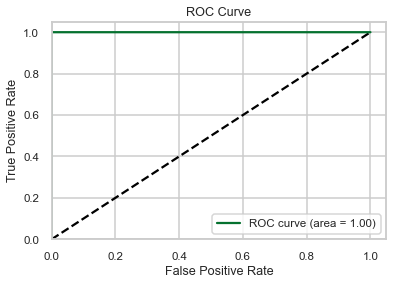

In [32]:
# random forest
rf = RandomForestClassifier(n_estimators=200, max_depth=3, 
                            criterion="entropy", random_state=47
                           )
rf.fit(X_train, y_train.values.ravel())
y_pred = rf.predict(X_test)

print("training size: {}".format(len(X_train)))
print("testing size: {}".format(len(X_test)))
accuracy = round(accuracy_score(y_test, y_pred), 2)
print("accuracy score: {}".format(accuracy))
print("hyperparameter(s): n_estimators=200, max_depth=3, criterion=entropy")
print("Confusion Matrix: {}".format(confusion_matrix(y_test, y_pred))) # TP, TN, FP, FN
print("Classification Report: {}".format(classification_report(y_test, y_pred)))
feature_importance = pd.DataFrame(rf.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print("feature importance: {}".format(feature_importance))

# plot precision recall curve
proba_rf = rf.predict_proba(X_test)[:, 1]
baseline_model = len(y_test[y_test.user_retained==1]) / len(y_test)

fpr, tpr, thresholds = roc_curve(y_test, proba_rf)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.show()

We can see that the most important feature is `trips_in_first_30_days`. This tells us that the drivers who take more trips in the first 30 days are more likely to become retained users. I suggest that more attention and rider incentives are given to drivers in the first 30 days to get them accustomed. 